### example usage of netlds package to fit PfLDS models

In [1]:
CODE_DIR = '/home/mattw/Dropbox/github/netlds/'  # location of netlds package
SAVE_DIR = '/home/mattw/results/temp/'           # where tf checkpoints will be saved

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, CODE_DIR)
from netlds.models import *
from netlds.generative import *
from netlds.inference import *
from data.sim_data import build_model

# create simulated data from the model 

In [2]:
# set simulation parameters
num_time_pts = 15  # time points per trajectory
dim_obs = 50  # observation dimension
dim_latent = 2  # latent dimension
obs_noise = 'gaussian'  # 'poisson' | 'gaussian'

# use a helper function located in data/sim_data.py to create simulated data:
# function builds a model and then draws samples from it 
# 'num_layers' parameter refers to number of hidden layers in a feed-forward 
# neural network that maps latents to observations
true_model, inf_net_params, gen_net_params = build_model(
    num_time_pts, dim_obs, dim_latent, num_layers=2, np_seed=1, obs_noise=obs_noise)

# save model parameters; necessary due to the way netlds code handles tf sessions
true_model.checkpoint_model(checkpoint_file=SAVE_DIR + 'true_model.ckpt', save_filepath=True)

# sample model; returns [num_samples x num_time_pts x dim_obs/latent] numpy arrays
ys, zs = true_model.sample(num_samples=128, seed=123)

INFO:tensorflow:Restoring parameters from /home/mattw/results/temp/true_model.ckpt


### plot samples from the simulation

Text(0,0.5,'Count')

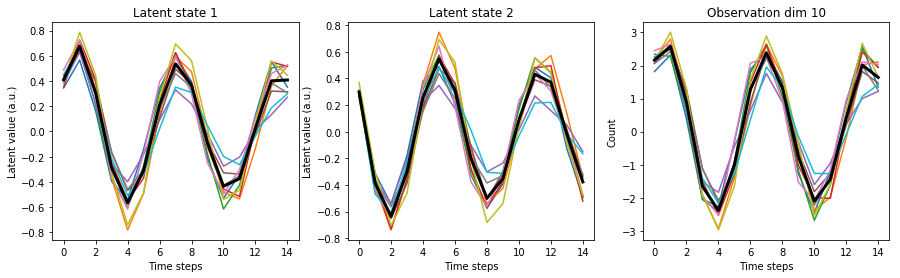

In [3]:
num_samples = 10

# plot latent states (samples + mean)
plt.figure(figsize=(15, 4))

plt.subplot(131)
for s in range(num_samples):
    plt.plot(zs[s, :, 0])
plt.plot(np.mean(zs[:num_samples, :, 0], axis=0), linewidth=3, color='k')
plt.title('Latent state 1')
plt.xlabel('Time steps')
plt.ylabel('Latent value (a.u.)')

plt.subplot(132)
for s in range(num_samples):
    plt.plot(zs[s, :, 1])
plt.plot(np.mean(zs[:num_samples, :, 1], axis=0), linewidth=3, color='k')
plt.title('Latent state 2')
plt.xlabel('Time steps')
plt.ylabel('Latent value (a.u.)')

# plot observations from one dimension
plt.subplot(133)
dim_to_plot = 10
for s in range(num_samples):
    plt.plot(ys[s, :, dim_to_plot])
plt.plot(np.mean(ys[:num_samples, :, dim_to_plot], axis=0), linewidth=3, color='k')
plt.title('Observation dim %i' % dim_to_plot)
plt.xlabel('Time steps')
plt.ylabel('Count')

# build the model
The netlds package fits a model that is specified by a generative model and an inference network

### 1. specify the generative model
The generative model class is defined in `netlds/generative.py`. To build a model one needs to specify the type of generative model (e.g. FLDS) and a dictionary of parameters (e.g. dimension of the observations and latent space, mapping from latents to observations, etc). 

In [4]:
gen_model = FLDS  # LDS | FLDS ('F' denotes neural network transfrom b/t z and y)

# initialize generative model params w/ sim params; this is necessary for poisson noise;
# need to come up with a better initialization scheme
if obs_noise == 'poisson':
    gen_params = gen_net_params['gen_params']
else:
    gen_params = None  # gaussian is fine
gen_model_params = {
    'dim_obs': dim_obs,
    'dim_latent': dim_latent,
    'num_time_pts': num_time_pts,
    'noise_dist': obs_noise,
    'nn_params': [{'units': 15}, {'units': 15}, {}], #} # 3 layer nn to output, last layer inferred
    'gen_params': gen_params}

### 2. specify the inference network
The inference model class is defined in `netlds/inference.py`. To build a model one needs to specify the structure of the approximate posterior (e.g. MeanFieldGaussian) and a dictionary of parameters (e.g. dimension of the network inputs and latent space, number of mc samples, etc). 

In [5]:
inf_network = SmoothingLDS  # SmoothingLDS | MeanFieldGaussian | MeanFieldGaussianTemporal
couple_params = True   # True to couple generative model and inference network params

# partially define the mapping from inference network input to parameters of approximate
# posterior
# all approximate posteriors are Gaussians with different parameterizations
# of the covariance matrix
# the output of the neural network defined below serves as input to two additional layers:
# one that maps to the mean of the Gaussian, and one that maps to parameters of the 
# covariance matrix that is (approximate posterior)-dependent; these additional mappings
# are handled by the code - see constructors of the various inference network classes for 
# more details
layer_params = {'units': 15, 'activation': 'tanh'}
nn_params = [layer_params, layer_params]

inf_network_params = {
    'dim_input': dim_obs,
    'dim_latent': dim_latent,
    'num_time_pts': num_time_pts,
    'nn_params': nn_params,
    'num_mc_samples': 4}

### 3. put them together

In [6]:
# initialize model; need to give model info about inference network and generative model
model = LDSModel(
    inf_network=inf_network, inf_network_params=inf_network_params,
    gen_model=gen_model, gen_model_params=gen_model_params, couple_params=couple_params)

# train the model

In [7]:
# set optimization parameters
if obs_noise == 'poisson':
    learning_rate = 1e-3
    epochs = 40
else:  # gaussian
    learning_rate = 1e-2
    epochs = 25
opt_params = {
    'learning_alg': 'adam',    # see Trainer._optimizer_ops for options
    'adam':                    # see Trainer._set_optimizer_defaults for options
        {'learning_rate': learning_rate}, 
    'epochs_training': epochs, # max iterations
    'epochs_display': 1,       # output to notebook
    'epochs_ckpt': np.inf,     # checkpoint model parameters (np.inf=last epoch only)
    'epochs_summary': None,    # output to tensorboard
    'batch_size': 4,           
    'use_gpu': True,           
    'run_diagnostics': False}  # record memory/compute time for tensorboard visualization

data_dict = {'observations': ys}
costs_train, _ = model.train(data=data_dict, opt_params=opt_params, output_dir=SAVE_DIR)

model checkpointed to /home/mattw/results/temp/checkpoints/init.ckpt
epoch 0000 (10.16 s):  avg train cost =   126.5122,  avg test cost =        nan
epoch 0001 (9.40 s):  avg train cost =    60.0340,  avg test cost =        nan
epoch 0002 (8.42 s):  avg train cost =    51.1940,  avg test cost =        nan
epoch 0003 (8.82 s):  avg train cost =    43.0025,  avg test cost =        nan
epoch 0004 (9.07 s):  avg train cost =    19.3303,  avg test cost =        nan
epoch 0005 (8.94 s):  avg train cost =    11.7908,  avg test cost =        nan
epoch 0006 (9.31 s):  avg train cost =     7.9553,  avg test cost =        nan
epoch 0007 (9.09 s):  avg train cost =     6.1863,  avg test cost =        nan
epoch 0008 (8.55 s):  avg train cost =     5.1512,  avg test cost =        nan
epoch 0009 (8.14 s):  avg train cost =     4.5417,  avg test cost =        nan
epoch 0010 (7.56 s):  avg train cost =     6.2443,  avg test cost =        nan
epoch 0011 (9.33 s):  avg train cost =     5.8554,  avg test 

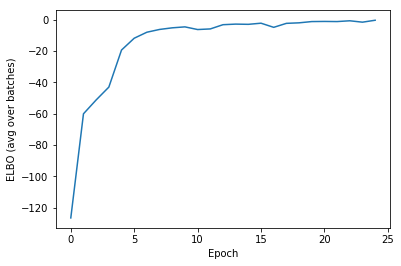

In [8]:
# plot ELBO across training epochs
plt.figure()
elbo = -np.array(costs_train) # since we are minimizing negative ELBO
epochs = np.arange(elbo.shape[0]) * opt_params['epochs_display']
plt.plot(epochs, elbo)
plt.ylabel('ELBO (avg over batches)')
plt.xlabel('Epoch')
plt.show()

# visualize model predictions

In [9]:
# get posterior means from model
posterior_means = model.get_posterior_means(input_data=ys)
# get average of inferred latents
avg_posterior_means = np.mean(posterior_means, axis=0)
# get average of sampled latents that generated data
z_avg = np.mean(zs, axis=0)

# latents are non-identifiable - find rotatation of average inferred latents that 
# most closely matches the average of the generating latent samples
rot_mat = np.linalg.lstsq(avg_posterior_means, z_avg)[0]
# rotate model samples
posterior_means_rot = np.matmul(posterior_means, rot_mat)
# rotate average of model samples
z_pred = np.matmul(avg_posterior_means, rot_mat)

INFO:tensorflow:Restoring parameters from /home/mattw/results/temp/checkpoints/epoch_00024.ckpt


/home/mattw/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


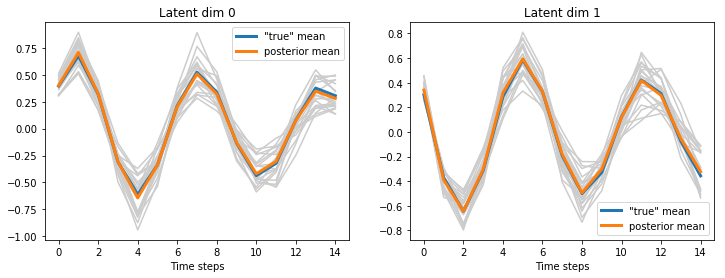

In [10]:
# plot latents
plt.figure(figsize=(12, 4))
num_rows = 1
num_cols = dim_latent
num_samples = 20  # number of samples from fitted model to plot
for l in range(dim_latent):
    plt.subplot(num_rows, num_cols, l + 1)
    for s in range(num_samples):
        plt.plot(posterior_means_rot[s, :, l], color=[0.8, 0.8, 0.8])
    plt.plot(z_avg[:, l], linewidth=3, label='"true" mean')
    plt.plot(z_pred[:, l], linewidth=3, label='posterior mean')
    plt.legend()
    plt.title('Latent dim %1i' % l)
    plt.xlabel('Time steps')
plt.show()